# Домашняя работа: "Методы оптимизации"

ФИО: Изуткина Александра

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

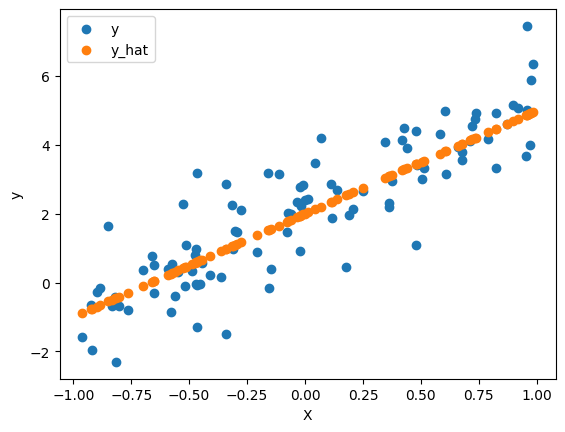

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

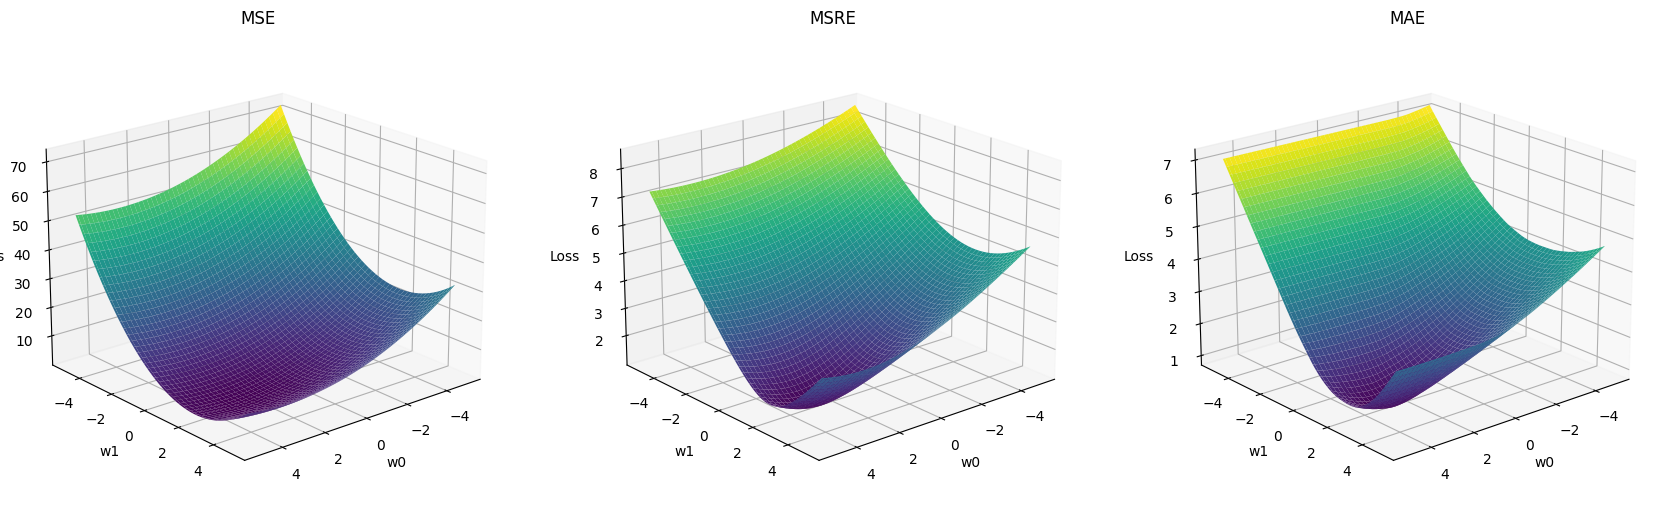

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [4]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [5]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [6]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [7]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [33]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.G = [0] * len(self.params)
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
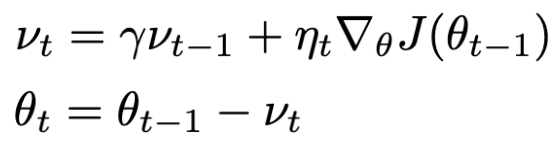

In [9]:
class Momentum(Optimizer):
    def __init__(self, params, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.v = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.v[i] = self.gamma * self.v[i] + self.eta * param.grad
                    param -= self.v[i]

#### AdaDelta
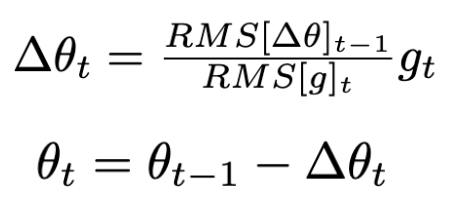

In [31]:
import random
random.seed(0)

class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-6, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.Eg = [random.random()] * len(self.params)
        self.Edx = [random.random()] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i,param in enumerate(self.params):
                if param.grad is not None:
                    self.Eg[i] = self.gamma * self.Eg[i] + (1 - self.gamma) * (param.grad  ** 2)
                    RMS_dx = (self.Edx[i] + self.eta)**(1/2)
                    RMS_g = (self.Eg[i] + self.eta)**(1/2)
                    update = (RMS_dx / RMS_g) * param.grad
                    param -= update
                    self.Edx[i] = self.gamma * self.Edx[i] + (1 - self.gamma) * (update ** 2)

#### Adam
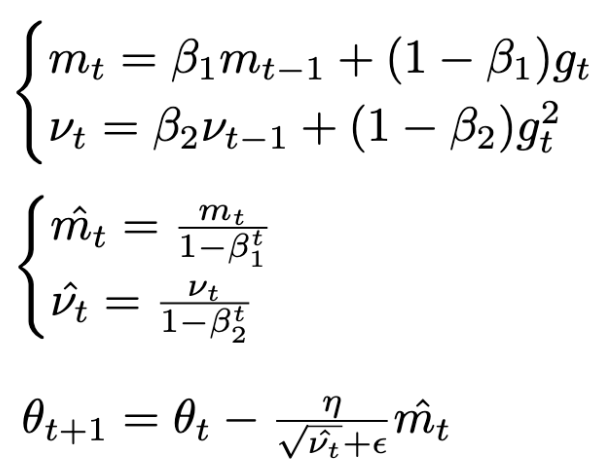

In [40]:
class Adam(Optimizer):
    def __init__(self, params, b1=0.9, b2=0.999, eta=1e-7, lr=0.001):
        super().__init__(params)
        self.b1 = b1
        self.b2 = b2
        self.eta = eta
        self.lr=lr
        self.m = [random.random()] * len(self.params)
        self.v = [random.random()] * len(self.params)
        self.t = 0

    def step(self):
        self.t += 1
        for i, param in enumerate(self.params):
            g = param.grad
            self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * g
            self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * g ** 2
            m_hat = self.m[i] / (1 - self.b1 ** self.t)
            v_hat = self.v[i] / (1 - self.b2 ** self.t)
            param.data -= self.lr * m_hat / (v_hat ** 0.5 + self.eta)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [ ]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Momentum, {'eta': 1e-2}, start_point=[-4, -4], num_iter=100)


In [ ]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)


In [ ]:
points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), Adam, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)


In [ ]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr':1e-1}],
        ['Momentum', Momentum, {'eta': 1e-2,'gamma': 0.9}],
        ['AdaGrad', AdaGrad, {'epsilon': 1e-8, 'eta': 1}],
        ['AdaDelta', AdaDelta, {'eta': 1e-8, 'gamma': 0.9}],
        ['Adam', Adam, {'b1': 0.9, 'b2': 0.99, 'eta': 1e-7, 'lr': 1}],
     ],
    start_point=[-4, -4],
    num_iter=40
)

Наибольшую скорость схождения показывает метод AdaDelta. Это связано с тем, что этот метод адаптирует величину шага спуска, используя скользящее среднее для оценки квадратов градиентов

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [12]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-10-04 14:51:43--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-10-04 14:51:44--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  8.38MB/s    in 5.2s    

2024-10-04 14:51:50 (6.41 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [13]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expansion_factor):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expansion_factor = expansion_factor

        self.conv1 = nn.Conv2d(in_channels, in_channels * expansion_factor, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels * expansion_factor)
        self.conv2 = nn.Conv2d(in_channels * expansion_factor, in_channels * expansion_factor, kernel_size=kernel_size, stride=stride, padding=(kernel_size - 1) // 2, groups=in_channels * expansion_factor, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels * expansion_factor)
        self.conv3 = nn.Conv2d(in_channels * expansion_factor, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU6()

    def forward(self, x):
        iden=x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.in_channels == self.out_channels and self.stride == 1:
            x = x + ident
        return x

class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_coefficient=1.1, depth_coefficient=1.2, dropout_rate=0.3):
        super(EfficientNet, self).__init__()
        self.num_classes = num_classes
        self.width_coefficient = width_coefficient
        self.depth_coefficient = depth_coefficient
        self.dropout_rate = dropout_rate

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6()
        )

        self.blocks = nn.ModuleList([
            MBConvBlock(32, 16, 3, 1, 1),
            MBConvBlock(16, 24, 3, 2, 6),
            MBConvBlock(24, 40, 5, 2, 6),
            MBConvBlock(40, 80, 3, 2, 6),
            MBConvBlock(80, 112, 5, 1, 6),
            MBConvBlock(112, 192, 5, 2, 6),
            MBConvBlock(192, 320, 3, 1, 6)
        ])

        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(1280, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.stem(x)
        for block in self.blocks:
            x = block(x)
        x = self.head(x)
        return x

In [42]:


def training(model,train_loader,criterion,optimizer,max_ep=8):
  losses=[]
  for epoch in range(max_ep):
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      losses.append(running_loss)
      print(running_loss)
  return losses

def evaluating(model,test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          test_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
  accuracy = correct / len(test_loader.dataset)
  print(f'Test Loss: {test_loss/len(test_loader)}')
  print(f'Test Accuracy: {accuracy}')



In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=EfficientNet().to(device)
cost=nn.CrossEntropyLoss()
model.to(device)
optimizer=Adam(model.parameters())
l1=training(model, train_loader, cost,optimizer)
evaluating(model,test_loader,cost)

4173.477803349495
3340.9780250787735
2867.545201063156
2823.1726739406586
2819.532329916954
2825.1470423936844
2835.8951610326767
2831.7555243968964
Test Loss: 1.4853932091984123
Test Accuracy: 0.9758


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=EfficientNet().to(device)
cost=nn.CrossEntropyLoss()
model.to(device)
optimizer=AdaDelta(model.parameters())
l2=training(model, train_loader, cost,optimizer)
evaluating(model,test_loader,cost)

3014.9292377233505
2848.4649506807327
2824.9279705286026
2815.767092227936
2807.6496237516403
2803.013663291931
2793.319271206856
2792.3421634435654
Test Loss: 1.481262812980067
Test Accuracy: 0.9798


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=EfficientNet().to(device)
cost=nn.CrossEntropyLoss()
model.to(device)
optimizer=AdaGrad(model.parameters())
l3=training(model, train_loader, cost,optimizer)
evaluating(model,test_loader,cost)

3037.0945559740067
2830.169164657593
2809.9835102558136
2797.993826150894
2789.005578637123
2782.681785106659
2777.914209485054
2774.5487360954285
Test Loss: 1.4796014833755005
Test Accuracy: 0.9817


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=EfficientNet().to(device)
cost=nn.CrossEntropyLoss()
model.to(device)
optimizer=SGD(model.parameters())
l4=training(model, train_loader, cost,optimizer)
evaluating(model,test_loader,cost)

3201.767280817032
2831.1899584531784
2801.2316167354584
2788.285092115402
2780.942939400673
2774.58818256855
2769.385380268097
2766.584109187126
Test Loss: 1.4744350575029659
Test Accuracy: 0.9876


### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

Запустите обучение, постройте график лоссов от эпохи:

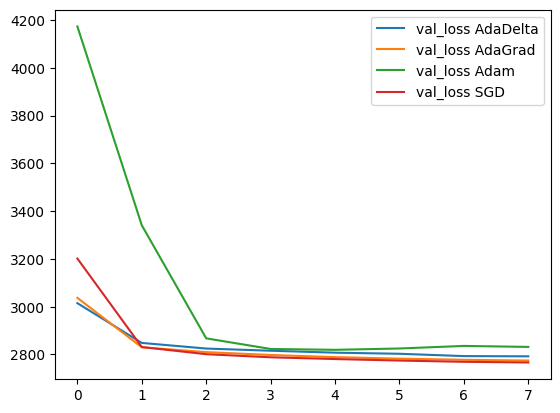

In [48]:
plt.plot(l2, label="val_loss AdaDelta")
plt.plot(l3, label="val_loss AdaGrad")
plt.plot(l1, label="val_loss Adam")
plt.plot(l4, label="val_loss SGD")
plt.legend()
plt.show()

Вывод: на данном датасете все 3 оптимизатора показывают хороший скор(больше 0.97 при num_epochs>5)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: